In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

plt.style.use('seaborn-v0_8-paper')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMAs
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.api import qqplot

#from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scipy.stats as stats

#import pmdarima as pm

plt.style.use('seaborn-v0_8-paper')

## Przygotowanie danych do analizy

In [2]:
df = pd.DataFrame()

for dirname, _, filenames in os.walk('imgw_temp'):
    for filename in filenames:
        df_temp = pd.read_csv(os.path.join(dirname, filename), delimiter=',', encoding='windows-1250',
                            names=['kod_stacji', 'nazwa_stacji', 'rok', 'miesiac', 'dzien', 'srednia_temperatura', 'status_temperatura',
                                     'srednia_wilgotnosc', 'status_wilgotnosc', 'srednia_p_wiatru', 'status_p_wiatru',
                                     'srednie_zachmurzenie', 'status_zachmurzenie'], dtype={'kod_stacji': str, 'rok': str, 'miesiac': str, 'dzien': str, 'srednia_temperatura': np.float64})
        df_temp.head()
        df = pd.concat([df, df_temp], ignore_index=True)

In [3]:
df['data'] = pd.to_datetime(df['rok'] + '-' + df['miesiac'] + '-' + df['dzien'], format='%Y-%m-%d')
df = df[df['data'] <= '2024-04-30']
df = df[['data', 'srednia_temperatura', 'kod_stacji', 'nazwa_stacji']]
df = df[df['nazwa_stacji'] == 'PSZCZYNA']
df = df[['data', 'srednia_temperatura']].groupby('data').mean().reset_index()
df.sort_values(by=['data'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,data,srednia_temperatura
0,2001-01-01,-5.7
1,2001-01-02,-2.7
2,2001-01-03,-1.5
3,2001-01-04,1.9
4,2001-01-05,2.8


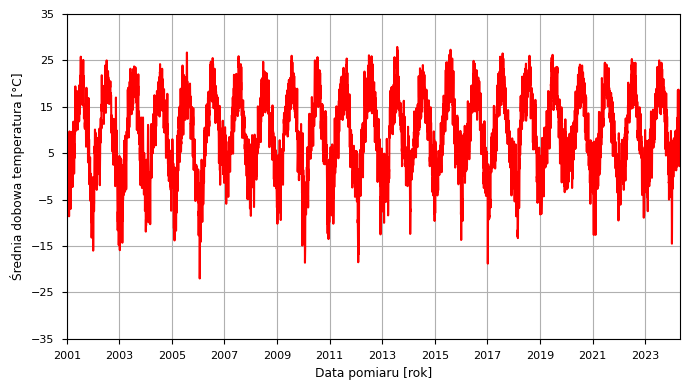

In [4]:
plt.figure(figsize=(7, 4))

plt.plot(df['data'], df['srednia_temperatura'], color='red', linewidth=1.5)

plt.xlabel('Data pomiaru [rok]')
plt.xticks(pd.date_range(start='2001-01-01', end='2024-04-30', freq='2YS'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2024-04-30'))
plt.ylabel('Średnia dobowa temperatura [°C]')
plt.yticks(np.arange(-35, 36, 10))
plt.ylim(-35, 35)

plt.grid()
plt.tight_layout()
plt.savefig('plots/imgw_temp.png', dpi=300)

In [5]:
print('Liczba braków danych', df['srednia_temperatura'].isnull().sum())
print('Rozmiar zbioru testowego', len(df))
print('Pierwsza data pomiaru', df['data'].min())
print('Ostatnia data pomiaru', df['data'].max())
print('Różnica między pierwszą a ostatnią datą pomiaru', df['data'].max() - df['data'].min())

Liczba braków danych 0
Rozmiar zbioru testowego 8521
Pierwsza data pomiaru 2001-01-01 00:00:00
Ostatnia data pomiaru 2024-04-30 00:00:00
Różnica między pierwszą a ostatnią datą pomiaru 8520 days 00:00:00


In [6]:
print('Najniższa temperatura', df['srednia_temperatura'].min())
print('Najwyższa temperatura', df['srednia_temperatura'].max())
print('Średnia temperatura', df['srednia_temperatura'].mean())
print('Odchylenie standardowe temperatury', df['srednia_temperatura'].std())
temp_min_3sigmy = df['srednia_temperatura'].mean() - 3 * df['srednia_temperatura'].std()
temp_max_3sigmy = df['srednia_temperatura'].mean() + 3 * df['srednia_temperatura'].std()
temp_min_3sigmy = round(temp_min_3sigmy)
temp_max_3sigmy = round(temp_max_3sigmy)
print('Zakres 3 sigmy', temp_min_3sigmy, temp_max_3sigmy)
print('Liczba pomiarów poniżej zakresu 3 sigmy', len(df[df['srednia_temperatura'] < temp_min_3sigmy]))
print('Pomiary poniżej zakresu 3 sigmy:\n', df[df['srednia_temperatura'] < temp_min_3sigmy])
print('Liczba pomiarów powyżej zakresu 3 sigmy', len(df[df['srednia_temperatura'] > temp_max_3sigmy]))

Najniższa temperatura -22.0
Najwyższa temperatura 27.9
Średnia temperatura 9.041063255486446
Odchylenie standardowe temperatury 8.380217749356639
Zakres 3 sigmy -16 34
Liczba pomiarów poniżej zakresu 3 sigmy 10
Pomiary poniżej zakresu 3 sigmy:
            data  srednia_temperatura
1848 2006-01-23                -22.0
1849 2006-01-24                -20.7
3310 2010-01-24                -18.6
3311 2010-01-25                -17.0
4049 2012-02-02                -16.3
4050 2012-02-03                -18.5
4051 2012-02-04                -17.3
4058 2012-02-11                -16.7
5850 2017-01-07                -18.8
5851 2017-01-08                -16.7
Liczba pomiarów powyżej zakresu 3 sigmy 0


In [7]:
df_test = df[df['data'] >= '2022-01-01']
df_tren = df[df['data'] < '2022-01-01']

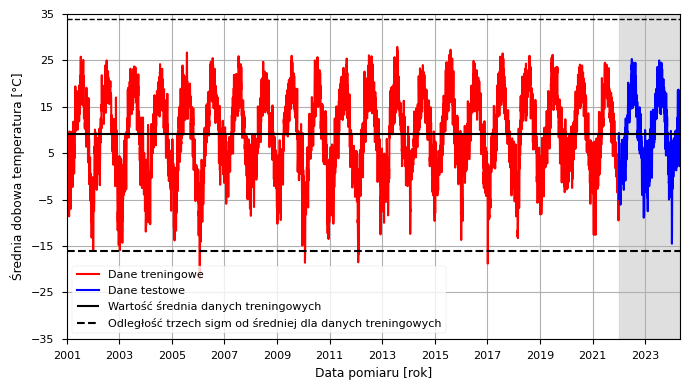

In [8]:
plt.figure(figsize=(7, 4))

plt.axvspan(df_test['data'].min(), df_test['data'].max(), color='gray', alpha=0.25)
plt.plot(df_tren['data'], df_tren['srednia_temperatura'], color='red', label='Dane treningowe', linewidth=1.5)
plt.plot(df_test['data'], df_test['srednia_temperatura'], color='blue', label='Dane testowe', linewidth=1.5)


plt.hlines(df['srednia_temperatura'].mean(), df['data'].min(), df['data'].max(), color='black', label='Wartość średnia danych treningowych', linewidth=1.5)
plt.hlines(temp_min_3sigmy, df['data'].min(), df['data'].max(), color='black', label='Odległość trzech sigm od średniej dla danych treningowych', linestyles='dashed', linewidth=1.5)
plt.hlines(temp_max_3sigmy, df['data'].min(), df['data'].max(), color='black', linestyles='dashed', linewidth=1)

plt.xlabel('Data pomiaru [rok]')
plt.xticks(pd.date_range(start='2001-01-01', end='2024-04-30', freq='2YS'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2024-04-30'))
plt.ylabel('Średnia dobowa temperatura [°C]')
plt.yticks(np.arange(-35, 36, 10))
plt.ylim(-35, 35)

plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('plots/imgw_temp_test.png', dpi=300)

In [9]:
print('Rozmiar zbioru treningowego', len(df_tren))
print('Rozmiar zbioru testowego', len(df_test))

Rozmiar zbioru treningowego 7670
Rozmiar zbioru testowego 851


In [10]:
t_cale = (df['data'] - df['data'].min()).dt.days
Xt_cale = df['srednia_temperatura']

t_test = (df_test['data'] - df['data'].min()).dt.days
Xt_test = df_test['srednia_temperatura']

t = (df_tren['data'] - df['data'].min()).dt.days
Xt = df_tren['srednia_temperatura']

### Wykresy ACF i PACF dla surowych danych

In [11]:
h_max = 365

def autokowariancja(proba, h):
    n = len(proba)
    sr = np.mean(proba)
    return 1/n*sum([(proba[i]-sr)*(proba[i+np.abs(h)]-sr) for i in np.arange(0, n-np.abs(h), 1)])
def autokorelacja(proba, h):
    return autokowariancja(proba, h)/autokowariancja(proba, 0)

hs = np.arange(0, h_max+1, 1)
acfs = [autokorelacja(Xt, h) for h in hs]
pacfs = pacf(Xt, nlags=h_max, method='yw')


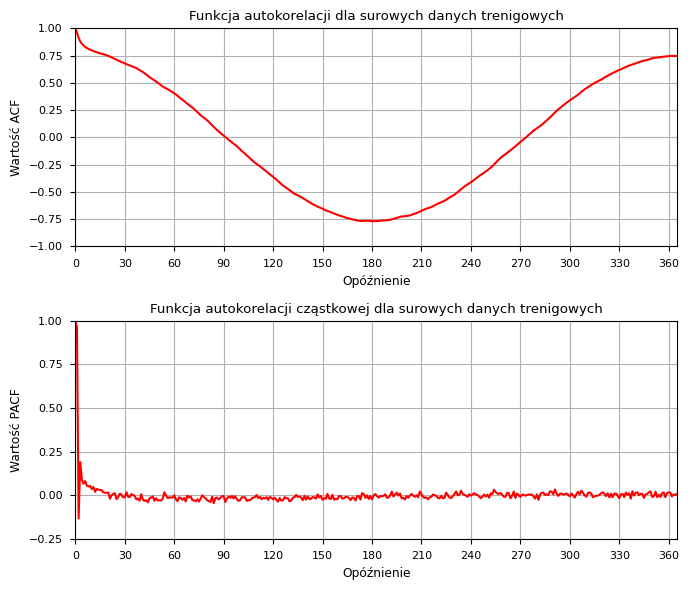

In [12]:
plt.figure(figsize=(7, 4*1.5))

# Wykres ACF
plt.subplot(2, 1, 1)
plt.plot(hs, acfs, color='red', linewidth=1.5)

plt.xlabel('Opóźnienie')
plt.xticks(np.arange(0, h_max, 30))
plt.xlim(0, h_max)

plt.ylabel('Wartość ACF')
plt.yticks(np.arange(-1, 1.01, 0.25))
plt.ylim(-1, 1)

plt.title('Funkcja autokorelacji dla surowych danych trenigowych')
plt.grid()

# Wykres PACF
plt.subplot(2, 1, 2)
plt.plot(hs, pacfs, color='red', linewidth=1.5)

plt.xlabel('Opóźnienie')
plt.xticks(np.arange(0, h_max, 30))
plt.xlim(0, h_max)

plt.ylabel('Wartość PACF')
plt.yticks(np.arange(-0.25, 1.01, 0.25))
plt.ylim(-0.25, 1)

plt.title('Funkcja autokorelacji cząstkowej dla surowych danych trenigowych')
plt.grid()


plt.tight_layout()
plt.savefig('plots/acf_pacf_raw.png', dpi=300)

### Test ADF dla surowych danych

In [13]:
from statsmodels.tsa.stattools import adfuller

# Test ADF z statsmodels
result = adfuller(Xt)
print('--- Wyniki testu ADF z statsmodels ---')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

# Interpretacja wyniku
if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Dane są stacjonarne (brak pierwiastka jednostkowego).")
else:
    print("Nie odrzucamy hipotezy zerowej. Dane mają pierwiastek jednostkowy (niestałe).")

print("\n")

# Uwaga! W literaturze znane są testy na tzw. seasonal unit root, np. HEGY Test, CH test. Adfuller możę odrzucić hipotezę o stacjonarności dla danych z sezonowością. Ale (chyba) wniosek będzie taki, że mamy niewielki trend.


--- Wyniki testu ADF z statsmodels ---
ADF Statistic: -5.7413868540417194
p-value: 6.263785353471402e-07
Critical Values: {'1%': np.float64(-3.431204762151373), '5%': np.float64(-2.86191774126888), '10%': np.float64(-2.566971067169163)}
Odrzucamy hipotezę zerową. Dane są stacjonarne (brak pierwiastka jednostkowego).




## Dekompozycja szeregu czasowego

In [14]:
def prosta_regresji(xs, ys):
    n = len(xs)
    mean_x = np.mean(xs)
    mean_y = np.mean(ys)
    b1_est = sum((xs[i]-mean_x)*(ys[i]-mean_y) for i in range(n))/sum((xs[i]-mean_x)**2 for i in range(n))
    b0_est = mean_y-b1_est*mean_x
    return b1_est, b0_est

a, b = prosta_regresji(t, Xt)
trend = lambda x: a*x+b

In [15]:
Xt_lin = [trend(x) for x in t]
Xt_without_lin  = Xt - Xt_lin

#### Periodogram

In [16]:
periodogram = np.abs(np.fft.fft(Xt_without_lin))**2 / len(Xt_without_lin)
frequencies = np.fft.fftfreq(len(Xt_without_lin))

In [17]:
peak_indices = np.argsort(periodogram)[::-1][:5] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print('Najwyższe wartości w periodogramie:')
for i, (peak_f, peak_p) in enumerate(zip(peaks_frequency, peaks_period)):
    print(f'{i+1}. częstotliwość: {peak_f:.4f}, okres: {peak_p:.2f} dni')

T = np.abs(peaks_period[:2]).mean()
print('Średni okres:', T)

Najwyższe wartości w periodogramie:
1. częstotliwość: 0.0027, okres: 365.24 dni
2. częstotliwość: -0.0027, okres: -365.24 dni
3. częstotliwość: -0.0023, okres: -426.11 dni
4. częstotliwość: 0.0023, okres: 426.11 dni
5. częstotliwość: -0.0121, okres: -82.47 dni
Średni okres: 365.23809523809524


C:\Users\Oliwia\AppData\Local\Temp\ipykernel_18104\210257266.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/frequencies[:len(frequencies)//2], periodogram[:len(periodogram)//2], color='red', linewidth=1.5)


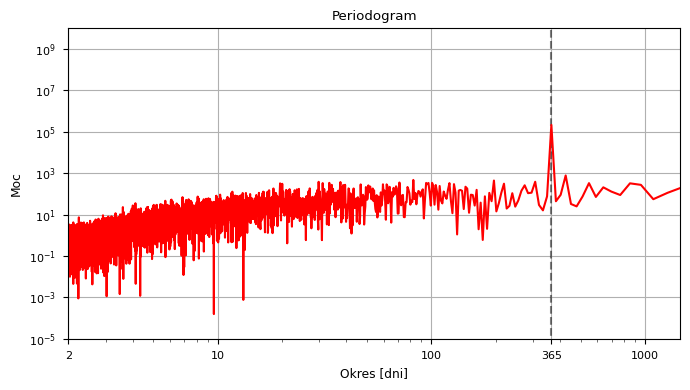

In [18]:
plt.figure(figsize=(7, 4))

plt.vlines(T, 0, 10**10, color='black', linestyles='dashed', label='Wytypowana częstotliwość', linewidth=1.5, alpha=0.5)
plt.plot(1/frequencies[:len(frequencies)//2], periodogram[:len(periodogram)//2], color='red', linewidth=1.5)

plt.xlabel('Okres [dni]')
plt.xscale('log')
plt.xlim(2, 365.25*4)
plt.xticks([2, 10, 100, T, 1000], ['2', '10', '100', f'{T:.0f}', '1000'])

plt.ylabel('Moc')
plt.yscale('log')
plt.ylim(10**-5, 10**10)

plt.grid()
plt.title("Periodogram")
plt.tight_layout()
plt.savefig('plots/imgw_temp_periodogram.png', dpi=300)

In [19]:
sine_func = lambda t, A, B, T: A * np.sin(2 * np.pi / T * (t + B))

p0 = [1, 0, T]
popt, pcov = curve_fit(sine_func, t, Xt_without_lin, p0=p0)
Xt_sin = sine_func(t, *popt)

Xt_without_lin_sin = Xt_without_lin - Xt_sin

print('Wartości parametrów dla funkcji sinusoidalnej dla danych treningowych:', popt)

Wartości parametrów dla funkcji sinusoidalnej dla danych treningowych: [ -10.60263584 -652.80972907  365.37337647]


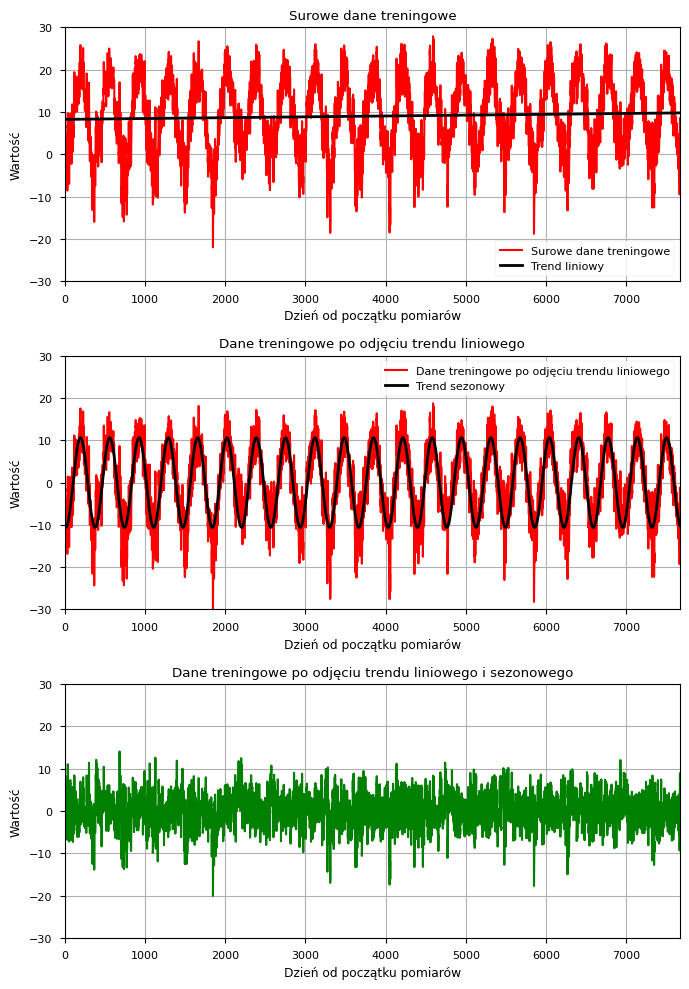

In [20]:
plt.figure(figsize=(7, 4*2.5))

plt.subplot(3, 1, 1)
plt.plot(t, Xt, color='red', linewidth=1.5, label='Surowe dane treningowe')
plt.plot(t, Xt_lin, color='black', linewidth=2, label='Trend liniowy')

plt.title('Surowe dane treningowe')
plt.xlabel('Dzień od początku pomiarów')
plt.xlim(0, len(t))
plt.ylabel('Wartość')
plt.ylim(-30, 30)

plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, Xt_without_lin, color='red', linewidth=1.5, label='Dane treningowe po odjęciu trendu liniowego')
plt.plot(t, Xt_sin, color='black', linewidth=2, label='Trend sezonowy')

plt.title('Dane treningowe po odjęciu trendu liniowego')
plt.xlabel('Dzień od początku pomiarów')
plt.xlim(0, len(t))
plt.ylabel('Wartość')
plt.ylim(-30, 30)

plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, Xt_without_lin_sin, color='green', linewidth=1.5)

plt.title('Dane treningowe po odjęciu trendu liniowego i sezonowego')
plt.xlabel('Dzień od początku pomiarów')
plt.xlim(0, len(t))
plt.ylabel('Wartość')
plt.ylim(-30, 30)

plt.grid()

plt.tight_layout()
plt.savefig('plots/imgw_temp_sin.png', dpi=300)


### Wykresy ACF i PACF dla uzyskanego szeregu

In [21]:
acfs = [autokorelacja(Xt_without_lin_sin, h) for h in hs]
pacfs = pacf(Xt_without_lin_sin, nlags=h_max, method='yw')


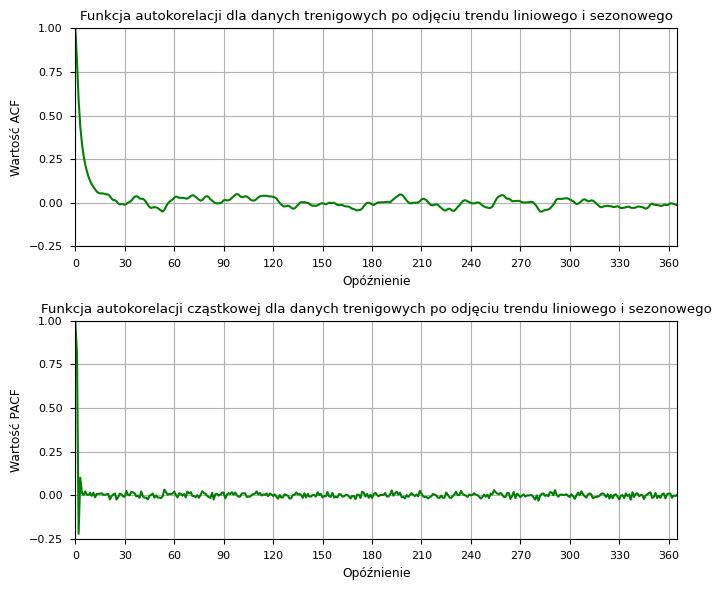

In [22]:
plt.figure(figsize=(7, 4*1.5))

# Wykres ACF
plt.subplot(2, 1, 1)
plt.plot(hs, acfs, color='green', linewidth=1.5)

plt.xlabel('Opóźnienie')
plt.xticks(np.arange(0, h_max, 30))
plt.xlim(0, h_max)

plt.ylabel('Wartość ACF')
plt.yticks(np.arange(-0.25, 1.01, 0.25))
plt.ylim(-0.25, 1)

plt.title('Funkcja autokorelacji dla danych trenigowych po odjęciu trendu liniowego i sezonowego')
plt.grid()

# Wykres PACF
plt.subplot(2, 1, 2)
plt.plot(hs, pacfs, color='green', linewidth=1.5)

plt.xlabel('Opóźnienie')
plt.xticks(np.arange(0, h_max, 30))
plt.xlim(0, h_max)

plt.ylabel('Wartość PACF')
plt.yticks(np.arange(-0.25, 1.01, 0.25))
plt.ylim(-0.25, 1)

plt.title('Funkcja autokorelacji cząstkowej dla danych trenigowych po odjęciu trendu liniowego i sezonowego')
plt.grid()

plt.tight_layout()
plt.savefig('plots/acf_pacf_clean.png', dpi=300)

### Test ADF dla uzyskanego szeregu

In [23]:
# Test ADF z statsmodels
result = adfuller(Xt_without_lin_sin)
print('--- Wyniki testu ADF z statsmodels ---')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

# Interpretacja wyniku
if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Dane są stacjonarne (brak pierwiastka jednostkowego).")
else:
    print("Nie odrzucamy hipotezy zerowej. Dane mają pierwiastek jednostkowy (niestałe).")

print("\n")

--- Wyniki testu ADF z statsmodels ---
ADF Statistic: -28.17820731131836
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4312032008261855), '5%': np.float64(-2.8619170513783763), '10%': np.float64(-2.5669706999315736)}
Odrzucamy hipotezę zerową. Dane są stacjonarne (brak pierwiastka jednostkowego).




## Modelowanie danych przy pomocy ARMA

### Dobranie rzędu modelu - kryteria informacyjne

In [24]:
# Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}

df = pd.DataFrame()

ps = []
qs = []
method_names = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 10
max_q = 1 # UWAGA!!! DLA WIĘKSZEGO MAX_Q WYSKAKUJE OSTRZEŻENIE: Non-invertible starting MA parameters found. Using zeros as starting parameters. Dlatego wystarczy, że sprawdzimy do 1 (te same wyniki). Niekoniezcnie musimy o tym pisać.
methods = ['statespace', 'innovations_mle', 'hannan_rissanen'] # DODATKOWA LINIJKA

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        for method in methods:
        
            # Dopasowanie modelu ARMA dla danego p i q
            model = ARIMA(Xt_without_lin_sin, order=(p, 0, q))
            model_fit = model.fit(method=method)
            
            # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
            ps.append(p)
            qs.append(q)
            method_names.append(method)
            AIC.append(model_fit.aic)
            BIC.append(model_fit.bic)
            HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC
df['Method'] = method_names

print(df)

    p  q           AIC           BIC          HQIC           Method
0   0  0  42619.336530  42633.226674  42624.100941       statespace
1   0  0  42619.336529  42633.226673  42624.100940  innovations_mle
2   0  0  42619.336529  42633.226673  42624.100940  hannan_rissanen
3   1  0  34248.842895  34269.678111  34255.989512       statespace
4   1  0  34248.842468  34269.677684  34255.989085  innovations_mle
5   1  0  34248.842557  34269.677773  34255.989174  hannan_rissanen
6   2  0  33860.614912  33888.395200  33870.143734       statespace
7   2  0  33860.614656  33888.394943  33870.143478  innovations_mle
8   2  0  33860.615038  33888.395326  33870.143860  hannan_rissanen
9   3  0  33785.880142  33820.605501  33797.791169       statespace
10  3  0  33785.879817  33820.605176  33797.790844  innovations_mle
11  3  0  33785.881017  33820.606376  33797.792044  hannan_rissanen
12  4  0  33786.753198  33828.423629  33801.046431       statespace
13  4  0  33786.752824  33828.423256  33801.0460

In [25]:
df.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC,Method
10,3,0,33785.879817,33820.605176,33797.790844,innovations_mle


In [26]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC,Method
10,3,0,33785.879817,33820.605176,33797.790844,innovations_mle


In [27]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC,Method
10,3,0,33785.879817,33820.605176,33797.790844,innovations_mle


### Estymacja parametrów modelu metodą MLE

In [28]:
model = ARIMA(Xt_without_lin_sin, order=(3, 0, 0)).fit(method='innovations_mle')
print("Wyniki:")
print(model.summary())


Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7670
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -16887.940
Date:                Wed, 29 Jan 2025   AIC                          33785.880
Time:                        08:47:01   BIC                          33820.605
Sample:                             0   HQIC                         33797.791
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.123     -0.013      0.990      -0.243       0.240
ar.L1          1.0191      0.010    102.456      0.000       1.000       1.039
ar.L2         -0.3223      0.014    -22.592 

In [29]:
# Wyciągamy parametry AR za pomocą .iloc[1:4]
parametry = model.params.iloc[1:5] 
print(parametry)

ar.L1     1.019137
ar.L2    -0.322305
ar.L3     0.099828
sigma2    4.785537
dtype: float64


## Ocena dopasowania modelu

### Przedziały ufności dla ACF

In [30]:
# DOPYTAĆ CZY TE PRZEDZIAŁY MAJĄ BYĆ WYZNACZONE SYMULACYJNIE TAK JAK WE WSPOMNIANYCH ZADANIACH DLA SZUMU Z ROZKŁADU NORMALNEGO

In [31]:
# Współczynniki wielomianu AR i MA

h_max=50
hs = np.arange(0, h_max+1, 1)

p1 = parametry.iloc[0]
p2 = parametry.iloc[1]
p3 = parametry.iloc[2]
sigma2 = parametry.iloc[3]

ar_coef = np.array([1, -p1, -p2])
ma_coef = np.array([1])
ar_process = ArmaProcess(ar_coef, ma_coef)

zbior_autk = []
zbior_autkor = []
przedzialy_kow_gora = []
przedzialy_kow_dol = []
przedzialy_kor_gora = []
przedzialy_kor_dol = []

N = 100                                                                                                   
n = 1000 
for n_i in range(N):
    autk=[]
    autkor=[]
    xs = ar_process.generate_sample(nsample=n, scale=np.sqrt(sigma2))
    for h in hs:
        autk.append(autokowariancja(xs, h))
        autkor.append(autokorelacja(xs, h))
    zbior_autk.append(autk)
    zbior_autkor.append(autkor)

alpha = 0.05

zbiory_kow_po_h = [[z[h_i] for z in zbior_autk] for h_i in range(len(hs))]
zbiory_kor_po_h = [[z[h_i] for z in zbior_autkor] for h_i in range(len(hs))]
for h_i in range(len(hs)):
    przedzialy_kow_gora.append(np.quantile(zbiory_kow_po_h[h_i], 1-alpha))
    przedzialy_kow_dol.append(np.quantile(zbiory_kow_po_h[h_i], alpha))
    przedzialy_kor_gora.append(np.quantile(zbiory_kor_po_h[h_i], 1-alpha))
    przedzialy_kor_dol.append(np.quantile(zbiory_kor_po_h[h_i], alpha))

autokow_teor = arma_acovf(ar_coef, ma_coef, nobs = h_max+1, sigma2=sigma2)
autokor_teo = arma_acf(ar_coef, ma_coef, lags=h_max+1)
autokow_emp = acovf(Xt_without_lin_sin, fft=True, nlag=h_max)
autokor_emp = acf(Xt_without_lin_sin, fft=True, nlags=h_max)

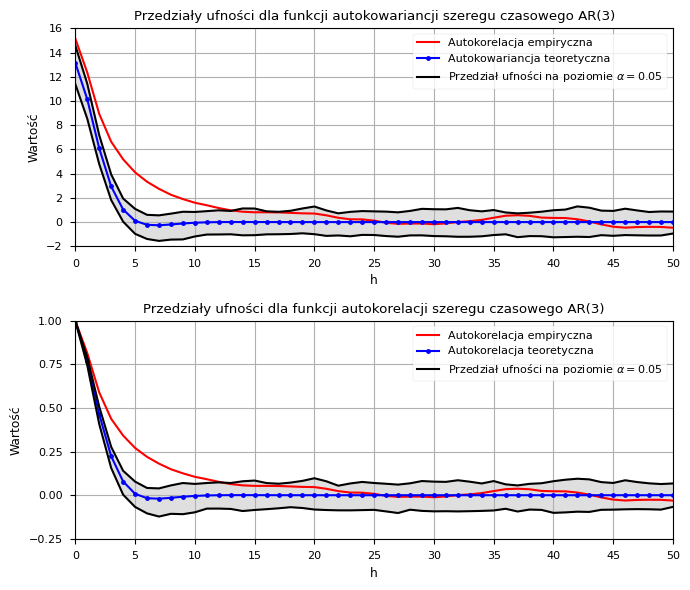

In [32]:
plt.figure(figsize=(7, 4*1.5))

# Wykres autokowariancji
plt.subplot(2, 1, 1)
plt.plot(hs, autokow_emp, color='red', linewidth=1.5, label='Autokorelacja empiryczna')
plt.plot(hs, autokow_teor, color='blue', linewidth=1.5, label='Autokowariancja teoretyczna', marker='o', markersize=3.5)
plt.plot(hs, przedzialy_kow_gora, color='black', linewidth=1.5, label=r'Przedział ufności na poziomie $\alpha = 0.05$')
plt.plot(hs, przedzialy_kow_dol, color='black', linewidth=1.5)
plt.fill_between(hs, przedzialy_kow_gora, przedzialy_kow_dol, color='gray', alpha=0.25)

plt.xlabel('h')
plt.xticks(np.arange(0, 51, 5))
plt.xlim(0, 50)

plt.ylabel('Wartość')
plt.yticks(np.arange(-2, 16.01, 2))
plt.ylim(-2, 16)

plt.title('Przedziały ufności dla funkcji autokowariancji szeregu czasowego AR(3)')
plt.legend(loc='upper right')
plt.grid()

# Wykres autokorelacji
plt.subplot(2, 1, 2)
plt.plot(hs, autokor_emp, color='red', linewidth=1.5, label='Autokorelacja empiryczna')
plt.plot(hs, autokor_teo, color='blue', linewidth=1.5, label='Autokorelacja teoretyczna', marker='o', markersize=3.5)
plt.plot(hs, przedzialy_kor_gora, color='black', linewidth=1.5, label=r'Przedział ufności na poziomie $\alpha = 0.05$')
plt.plot(hs, przedzialy_kor_dol, color='black', linewidth=1.5)
plt.fill_between(hs, przedzialy_kor_gora, przedzialy_kor_dol, color='gray', alpha=0.25)

plt.xlabel('h')
plt.xticks(np.arange(0, 51, 5))
plt.xlim(0, 50)

plt.ylabel('Wartość')
plt.yticks(np.arange(-0.25, 1.01, 0.25))
plt.ylim(-0.25, 1)

plt.title('Przedziały ufności dla funkcji autokorelacji szeregu czasowego AR(3)')
plt.legend(loc='upper right')
plt.grid()


plt.tight_layout()
plt.savefig('plots/acvf_acf_ar3.png', dpi=300)

In [33]:
# Na podstawie przedziałów udfności: czy model jest dobrze dopasowany? Czy tu wystarczy napisać zdanie, że wartości ACF mieszczą się w przedziale ufności, co widać na wykresie?
# Czy pisać o tym, że dla małych h coś się nie zgadza?

### Przedziały ufności dla PACF

In [34]:
# Parametry
N = 100  # Liczba symulacji
n = 1000  # Rozmiar próbek
alpha = 0.05  # Poziom ufności

# Generowanie próbek i PACF w jednej pętli
zbior_pacfs = []
for _ in range(N):
    xs = ar_process.generate_sample(nsample=n, scale=np.sqrt(sigma2))
    zbior_pacfs.append(pacf(xs, nlags=h_max, method='yw'))

# Obliczanie przedziałów ufności (opt)
zbior_pacfs_array = np.array(zbior_pacfs)
przedzial_gora = np.quantile(zbior_pacfs_array, 1-alpha, axis=0)
przedzial_dol = np.quantile(zbior_pacfs_array, alpha, axis=0)

# PACF teoretyczna i empiryczna
pacf_teo = arma_pacf(ar_coef, ma_coef, lags=h_max+1)
pacf_emp = pacf(Xt_without_lin_sin, nlags=h_max, method='yw')

hs = np.arange(h_max + 1)

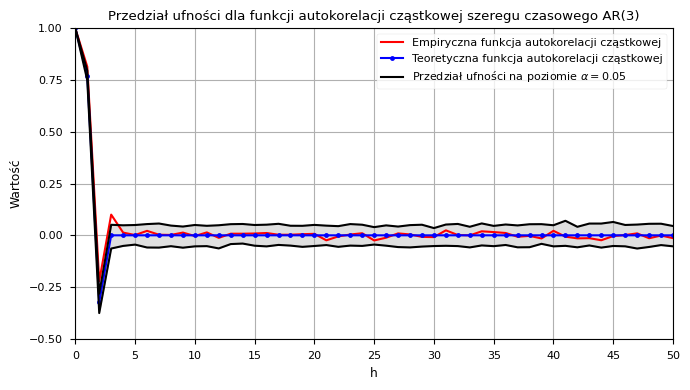

In [35]:
plt.figure(figsize=(7, 4))

plt.plot(hs, pacf_emp, color='red', linewidth=1.5, label='Empiryczna funkcja autokorelacji cząstkowej')
plt.plot(hs, pacf_teo, color='blue', linewidth=1.5, label='Teoretyczna funkcja autokorelacji cząstkowej', marker='o', markersize=3.5)
plt.plot(hs, przedzial_gora, color='black', linewidth=1.5, label=r'Przedział ufności na poziomie $\alpha = 0.05$')
plt.plot(hs, przedzial_dol, color='black', linewidth=1.5)
plt.fill_between(hs, przedzial_gora, przedzial_dol, color='gray', alpha=0.25)

plt.xlabel('h')
plt.xticks(np.arange(0, 51, 5))
plt.xlim(0, 50)

plt.ylabel('Wartość')
plt.yticks(np.arange(-0.5, 1.01, 0.25))
plt.ylim(-0.5, 1)

plt.title('Przedział ufności dla funkcji autokorelacji cząstkowej szeregu czasowego AR(3)')
plt.legend(loc='upper right')
plt.grid()

plt.tight_layout()
plt.savefig('plots/pacf.png', dpi=300)

### Porównanie linii kwantylowych z trajektorią

In [36]:
n = len(Xt_without_lin_sin)
simulations = np.array([ar_process.generate_sample(nsample=n, scale=np.sqrt(sigma2)) for _ in range(10**4)])
quantiles = np.percentile(simulations, np.arange(10, 100, 10), axis=0)

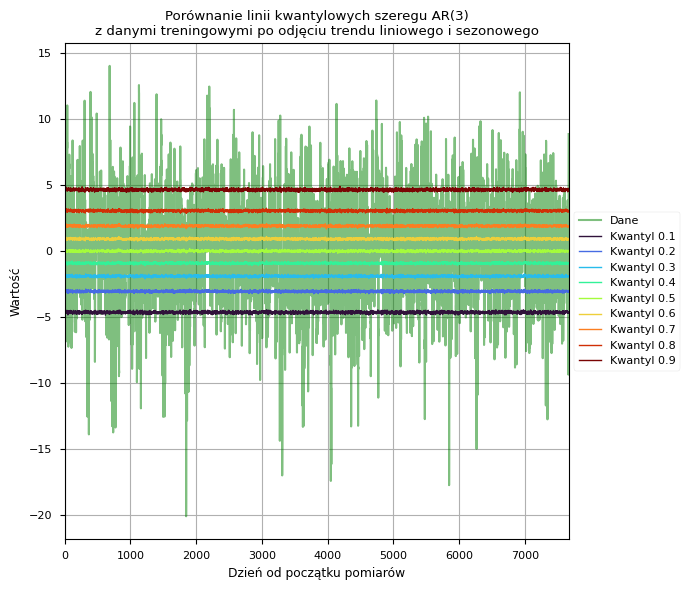

In [50]:
plt.figure(figsize=(7, 4*1.5))


plt.plot(t, Xt_without_lin_sin, color='green', alpha=0.5, linewidth=1.5, label='Dane')
for i in np.arange(0, 9, 1):
    color = plt.cm.turbo(i/8)
    plt.plot(t, quantiles[i], color=color, linewidth=1, label=f'Kwantyl {(i+1)/10}')

plt.xlabel('Dzień od początku pomiarów')
plt.xlim(0, len(t))

plt.ylabel('Wartość')

plt.title('Porównanie linii kwantylowych szeregu AR(3)\nz danymi treningowymi po odjęciu trendu liniowego i sezonowego')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.tight_layout()
plt.savefig('plots/quantiles.png', dpi=300)

In [241]:
procenty = []
for i in range(8):  # mamy 8 przedziałów, bo 9 kwantyli
    lower_bound = quantiles[i]  # dolna granica przedziału (i-tego kwantyla)
    upper_bound = quantiles[i+1]  # górna granica przedziału ((i+1)-szy kwantyl)
    
    # Liczymy, ile obserwacji mieści się w przedziale
    count_in_interval = np.sum((Xt_without_lin_sin >= lower_bound) & (Xt_without_lin_sin < upper_bound))
    percentage = (count_in_interval / len(Xt_without_lin_sin)) * 100
    procenty.append(percentage)

# Tworzymy DataFrame z wynikami
tabela = pd.DataFrame({
    'Przedział (Qn-Qn+1)': [f'Q{i/10:.1f} - Q{(i+1)/10:.1f}' for i in range(8)],
    'Procent obserwacji': procenty
})

# Wyświetlamy tabelę
print(tabela)

# Zapisujemy tabelę do pliku CSV, jeśli jest to potrzebne
tabela.to_csv('quantile_intervals_percentages.csv', index=False)

  Przedział (Qn-Qn+1)  Procent obserwacji
0         Q0.0 - Q0.1            9.921773
1         Q0.1 - Q0.2            9.139505
2         Q0.2 - Q0.3            9.322034
3         Q0.3 - Q0.4            9.543677
4         Q0.4 - Q0.5            9.113429
5         Q0.5 - Q0.6           10.677966
6         Q0.6 - Q0.7           10.247718
7         Q0.7 - Q0.8           10.651890


### Prognoza dla przyszłych obserwacji + porównanie

In [38]:
# Długość danych testowych
n = len(t_test)

# Symulacje z modelu AR(3)
simulations = np.array([ar_process.generate_sample(nsample=n, scale=np.sqrt(sigma2)) for _ in range(1000)])

# Dodanie deterministycznej prognozy (trend + sin)
deterministic_part = np.array([trend(t) + sine_func(t, *popt) for t in t_test])
simulations_with_trend = simulations + deterministic_part  # Dodajemy prognozę deterministyczną do symulacji

# Obliczenie kwantyli empirycznych
quantiles = np.percentile(simulations_with_trend, [5, 50, 95], axis=0)


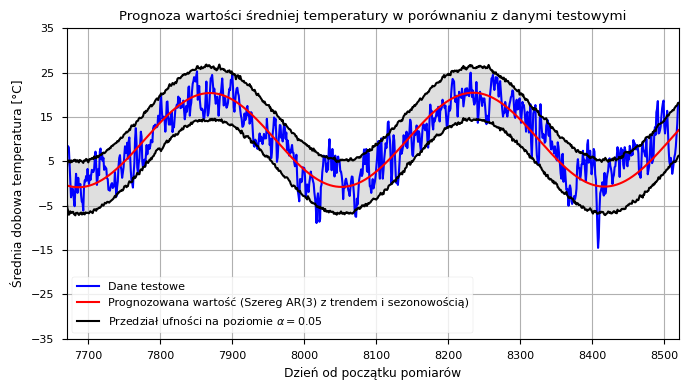

In [39]:
plt.figure(figsize=(7, 4))

plt.plot(t_test, Xt_test, color='blue', linewidth=1.5, label='Dane testowe')
plt.plot(t_test, deterministic_part, color='red', linewidth=1.5, label='Prognozowana wartość (Szereg AR(3) z trendem i sezonowością)')
plt.plot(t_test, quantiles[2], color='black', linewidth=1.5, label=r'Przedział ufności na poziomie $\alpha = 0.05$')
plt.plot(t_test, quantiles[0], color='black', linewidth=1.5)
plt.fill_between(t_test, quantiles[2], quantiles[0], color='gray', alpha=0.25)

plt.xlabel('Dzień od początku pomiarów')
plt.xlim(np.min(t_test), np.max(t_test))

plt.ylabel('Średnia dobowa temperatura [°C]')
plt.yticks(np.arange(-35, 36, 10))
plt.ylim(-35, 35)

plt.title('Prognoza wartości średniej temperatury w porównaniu z danymi testowymi')
plt.legend(loc='lower left')
plt.grid()

plt.tight_layout()
plt.savefig('plots/prediction.png', dpi=300)

## Weryfikacja założeń dot. szumu

### Zał. dot. średniej (wykres wartości resztowych / t test)

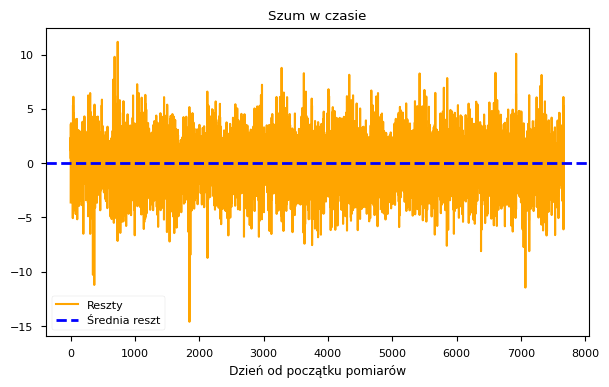

T-statystyka: 0.0290, p-value: 0.9768
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia szumu wynosi zero.


In [243]:
residuals = model.resid

# Tworzymy wykres
plt.figure(figsize=(7, 4))
plt.plot(residuals, color='orange', label='Reszty', linewidth=1.5)
plt.axhline(residuals.mean(), color='blue', linestyle='--', label='Średnia reszt', linewidth=2)

# Dodajemy tytuł i opisy osi
plt.title("Szum w czasie")
plt.xlabel("Dzień od początku pomiarów")


# Dodajemy legendę
plt.legend()
plt.savefig('plots/residuals.png', dpi=300)
plt.show()

# Test t-Studenta dla średniej reszt
t_stat, p_value = stats.ttest_1samp(residuals, popmean=0)
print(f"T-statystyka: {t_stat:.4f}, p-value: {p_value:.4g}")

# Wniosek
if p_value < 0.05:
    print("Odrzucamy hipotezę zerową: średnia szumu nie wynosi zero.")
else:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia szumu wynosi zero.")

### Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

In [153]:
from statsmodels.stats.diagnostic import het_arch

# Test ARCH
arch_stat, arch_p, _, _ = het_arch(residuals)
print(f"ARCH Test: Statystyka = {arch_stat:.4f}, p-value = {arch_p:.4g}")

# Wniosek
if arch_p < 0.05:
    print("Odrzucamy hipotezę zerową: wariancja reszt wykazuje autokorelację (heteroskedastyczność).")
else:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.")

ARCH Test: Statystyka = 136.5453, p-value = 2.149e-24
Odrzucamy hipotezę zerową: wariancja reszt wykazuje autokorelację (heteroskedastyczność).


In [154]:
from scipy.stats import levene

for i in np.arange(2, 30):
    # Tworzymy sztuczne podgrupy (np. dzielimy reszty na 4 grupy)
    n_groups = i
    group_size = len(residuals) // n_groups

    # Dzielimy reszty na grupy
    groups = [residuals[i * group_size: (i + 1) * group_size] for i in range(n_groups)]

    # Levene Test
    levene_stat, levene_p = levene(*groups, center='median')
    #print(f"Modified Levene Test: Statystyka = {levene_stat:.4f}, p-value = {levene_p:.4g}")
    print(f'Dla {i} prób:')

    # Wniosek
    if levene_p < 0.05:
        print("Odrzucamy hipotezę zerową: wariancja reszt nie jest stała.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.")

Dla 2 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 3 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 4 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 5 prób:
Odrzucamy hipotezę zerową: wariancja reszt nie jest stała.
Dla 6 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 7 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 8 prób:
Odrzucamy hipotezę zerową: wariancja reszt nie jest stała.
Dla 9 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 10 prób:
Odrzucamy hipotezę zerową: wariancja reszt nie jest stała.
Dla 11 prób:
Nie ma podstaw do odrzucenia hipotezy zerowej: wariancja reszt jest stała.
Dla 12 prób:
Odrzucamy hipotezę zerową: wariancja reszt nie jest stała.
Dla 13 prób:
Odrzucamy hipotezę zerową: wariancja reszt nie jest stała.
Dla 14 prób:
Odrzucamy hipotezę 

### Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

In [155]:
h_max = 20
hs = np.arange(0, h_max+1, 1)
acfs = [autokorelacja(residuals, h) for h in hs]
pacfs = pacf(residuals, nlags=h_max, method='yw')

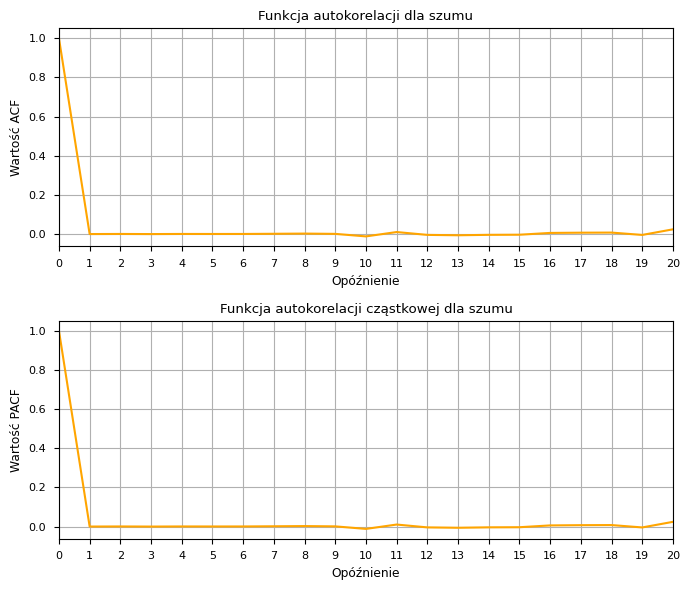

In [244]:
plt.figure(figsize=(7, 4*1.5))

# Wykres ACF
plt.subplot(2, 1, 1)
plt.plot(hs, acfs, color='orange', linewidth=1.5)

plt.xlabel('Opóźnienie')
plt.xlim(0, h_max)
plt.xticks(hs)

plt.ylabel('Wartość ACF')

plt.title('Funkcja autokorelacji dla szumu')
plt.grid()

# Wykres PACF
plt.subplot(2, 1, 2)
plt.plot(hs, pacfs, color='orange', linewidth=1.5)

plt.xlabel('Opóźnienie')
plt.xlim(0, h_max)
plt.xticks(hs)

plt.ylabel('Wartość PACF')

plt.title('Funkcja autokorelacji cząstkowej dla szumu')
plt.grid()


plt.tight_layout()
plt.savefig('plots/acf_pacf_residuals.png', dpi=300)
plt.show()

In [157]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test Ljunga-Boxa dla różnych opóźnień
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)

# Drukowanie wyników
print(lb_test)

# Interpretacja wyników
for lag, p_value in zip([10, 20, 30], lb_test["lb_pvalue"]):
    if p_value < 0.05:
        print(f"Dla {lag} opóźnień: p-value = {p_value:.4f} → Odrzucamy H0, reszty wykazują autokorelację.")
    else:
        print(f"Dla {lag} opóźnień: p-value = {p_value:.4f} → Brak podstaw do odrzucenia H0, reszty są niezależne.")

      lb_stat  lb_pvalue
10   1.195125   0.999613
20   8.246274   0.990109
30  21.661661   0.866065
Dla 10 opóźnień: p-value = 0.9996 → Brak podstaw do odrzucenia H0, reszty są niezależne.
Dla 20 opóźnień: p-value = 0.9901 → Brak podstaw do odrzucenia H0, reszty są niezależne.
Dla 30 opóźnień: p-value = 0.8661 → Brak podstaw do odrzucenia H0, reszty są niezależne.


### Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

In [158]:
# Testy na normalność
def perform_normality_tests(data):
    Z = (data - data.mean()) / data.std()

    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(Z)
    shapiro_result = "Odrzucamy hipotezę zerową. Rozkład nie jest normalny." if shapiro_p < 0.05 else "Nie ma podstaw do odrzucenia hipotezy zerowej. Rozkład jest normalny."

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest(Z, stats.norm.cdf)
    ks_result = "Odrzucamy hipotezę zerową. Rozkład nie jest normalny." if ks_p < 0.05 else "Nie ma podstaw do odrzucenia hipotezy zerowej. Rozkład jest normalny."

    # Normaltest (D'Agostino and Pearson)
    normaltest_stat, normaltest_p = stats.normaltest(Z)
    normaltest_result = "Odrzucamy hipotezę zerową. Rozkład nie jest normalny." if normaltest_p < 0.05 else "Nie ma podstaw do odrzucenia hipotezy zerowej. Rozkład jest normalny."

    # Print Results
    print(f"Shapiro-Wilk: Statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4g}. {shapiro_result}")
    print(f"Kolmogorov-Smirnov: Statystyka = {ks_stat:.4f}, p-value = {ks_p:.4g}. {ks_result}")
    print(f"Normaltest: Statystyka = {normaltest_stat:.4f}, p-value = {normaltest_p:.4g}. {normaltest_result}")

perform_normality_tests(residuals)

Shapiro-Wilk: Statystyka = 0.9936, p-value = 5.313e-18. Odrzucamy hipotezę zerową. Rozkład nie jest normalny.
Kolmogorov-Smirnov: Statystyka = 0.0215, p-value = 0.001637. Odrzucamy hipotezę zerową. Rozkład nie jest normalny.
Normaltest: Statystyka = 181.0727, p-value = 4.793e-40. Odrzucamy hipotezę zerową. Rozkład nie jest normalny.


C:\Users\Admin\AppData\Local\Temp\ipykernel_14612\2380768707.py:6: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7670.
  shapiro_stat, shapiro_p = stats.shapiro(Z)


In [ ]:
residuals_normalized = (residuals - np.mean(residuals)) / np.std(residuals)


plt.figure(figsize=(7, 4))
qqplot(residuals_normalized, line='45', ax=plt.gca(), markerfacecolor='orange')
plt.gca().get_lines()[1].set_color('blue')
plt.gca().get_lines()[1].set_alpha(0.5)
plt.title('Wykres Q-Q dla reszt')
plt.ylabel("Kwantyle dla szumu")
plt.xlabel("Kwantyle dla rozkładu normalnego")
plt.savefig('plots/qqplot_residuals.png', dpi=300)
plt.show()

NameError: name 'residuals' is not defined

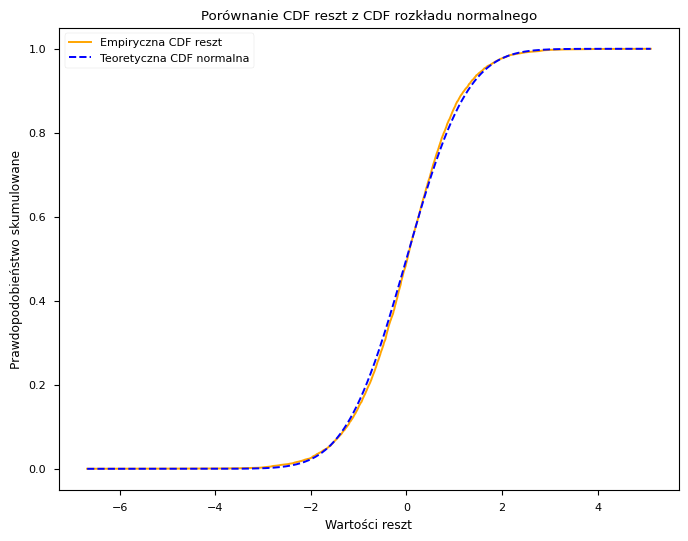

C:\Users\Admin\AppData\Local\Temp\ipykernel_14612\1519784226.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, stats.norm.pdf(x), 'r--', label='Teoretyczna PDF normalna', color='blue')


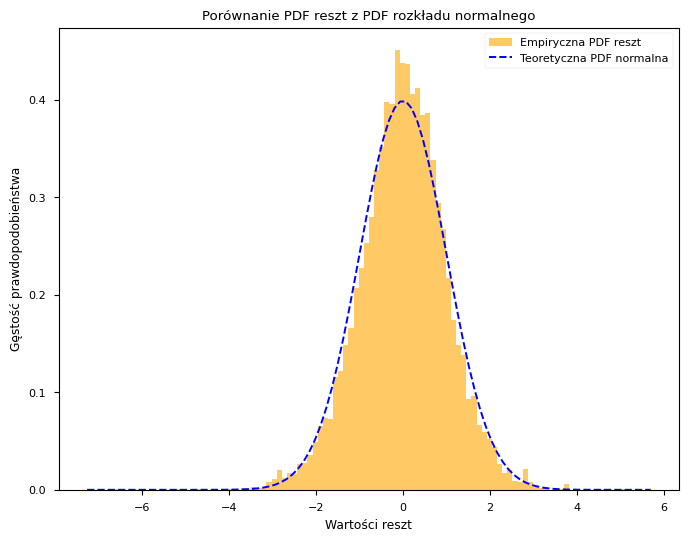

In [247]:
# Wykres porównania CDF
plt.figure(figsize=(7, 4))

# Obliczanie empirycznej CDF
sorted_residuals = np.sort(residuals_normalized)
cdf_residuals = np.arange(1, len(residuals_normalized) + 1) / len(residuals_normalized)

# Porównanie z teoretyczną CDF rozkładu normalnego
plt.plot(sorted_residuals, cdf_residuals, label="Empiryczna CDF reszt", color='orange')
plt.plot(sorted_residuals, stats.norm.cdf(sorted_residuals), label="Teoretyczna CDF normalna", color='blue', linestyle='dashed')

plt.title('Porównanie CDF reszt z CDF rozkładu normalnego')
plt.xlabel('Wartości reszt')
plt.ylabel('Prawdopodobieństwo skumulowane')
plt.legend()
plt.savefig('plots/cdf_residuals.png', dpi=300)
plt.show()

# Wykres porównania gęstości (PDF)
plt.figure(figsize=(7, 4))

# Histogram empirycznej gęstości reszt
plt.hist(residuals_normalized, bins=100, density=True, alpha=0.6, color='orange', label='Empiryczna PDF reszt')

# Nałożenie teoretycznej gęstości normalnej
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x), 'r--', label='Teoretyczna PDF normalna', color='blue')

plt.title('Porównanie PDF reszt z PDF rozkładu normalnego')
plt.xlabel('Wartości reszt')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.legend()
plt.savefig('plots/pdf_residuals.png', dpi=300)
plt.show()
